# Projections and uncertainties of future winter windstorm damage in Europe
## Notebook 3: Uncertainty and sensitivity quantification
This notebook reproduces the results of the uncertainty and sensitivity analysis of the publication Projections and uncertainties of future winter windstorm damage in Europe. The hazard data must be pre-processed beforehand using the notebook 1. The CLIMADA package needs to be installed. See tutorial on https://github.com/CLIMADA-project/climada_python/blob/main/doc/guide/Guide_Installation.ipynb for guidance to install CLIMADA. See tutorial https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/1_main_climada.ipynb for guidance to use CLIMADA. Exposure data is loaded using LitPop (see tutorial https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/climada_entity_LitPop.ipynb). The uncertainty and sensitivity analysis is done using the delta_impact submodule of the unsequa module, available on the develop branch (see tutorial https://github.com/CLIMADA-project/climada_python/blob/main/doc/tutorial/climada_engine_unsequa.ipynb).


In [1]:
import numpy as np
import copy as cp
import pandas as pd
import scipy as sp
import geopandas as gpd
import seaborn as sns
from timeit import default_timer as timer

#CLIMADA
from climada.engine import Impact
from climada.entity import ImpactFunc,ImpactFuncSet, Exposures
from climada.entity.impact_funcs import storm_europe
from climada.hazard import Hazard
from climada.engine.unsequa import InputVar, CalcImpact, CalcDeltaImpact
idx = pd.IndexSlice

#custom
from constants import *
from functions_projUncWS import *

import warnings
warnings.filterwarnings('ignore') #Ignore warnings for making the tutorial's pdf.
warnings.simplefilter('ignore')
import logging
from climada.util.config import LOGGER
LOGGER.setLevel(logging.ERROR) #Ignore CLIMADA warnings for making the tutorial's pdf.

/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
#plotting params
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as mcolors
#plt.style.use('tableau-colorblind10')
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 24
mpl.rcParams['axes.titleweight'] = 'bold'
mpl.rcParams['axes.titlesize'] = MEDIUM_SIZE
mpl.rcParams['axes.titlelocation'] = 'left'
mpl.rcParams['axes.labelsize'] = MEDIUM_SIZE
mpl.rcParams['axes.labelweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = SMALL_SIZE
mpl.rcParams['ytick.labelsize'] = SMALL_SIZE
mpl.rcParams['legend.fontsize'] = SMALL_SIZE
tab_cols = mcolors.TABLEAU_COLORS
clist = mpl.rcParams['axes.prop_cycle']


In [3]:
#setup folders and folder variables.
# All these variables need to be defined correctly for the code to work.
# The strings in these variables should point to existing folders on your computer.
project_folder = '/Users/lseverino/Documents/Publi MT/Model code Proj.-unc.-WS-damage'
data_folder = project_folder+'/data/' #this folder will contain the netcdf files downloaded by this script
results_folder = project_folder+'/results/' #this folder will contain results (e.g. climada impact data)
                                                            # produced by this script
file_identifier = '_v01' # this string is added to all files written by this code

### Prepare data
First define countries for regional assessments

In [4]:
##Prepare country lists for regional damage assessment

EU_countries = ['Andorra', 'Albania', 'Austria', 'Belgium', 'Bulgaria', 'Belarus', 'Czechia', 'Germany',
                'Denmark', 'Estonia', 'Finland', 'France', 'Greece', 'Hungary', 'Italy', 'Liechtenstein', 'Lithuania',
                'Luxembourg', 'Latvia', 'Malta', 'Netherlands', 'Norway', 'Poland', 'Portugal', 'Romania',
                'Sweden', 'Slovenia', 'Slovakia', 'San Marino', 'Ukraine', 'Bosnia and Herzegovina', 'Croatia', 'Moldova',
                'Monaco', 'Montenegro', 'Serbia', 'Spain', 'Switzerland', 'United Kingdom of Great Britain and Northern Ireland', 'Vatican City State', 'Ireland',
                'Moldova, Republic of', 'Macedonia, the former Yugoslav Republic of']#'United Kingdom','Czech Republic'
#regions
BI = ['United Kingdom of Great Britain and Northern Ireland','Ireland']
IP = ['Spain', 'Portugal','Andorra']
WEU = ['France','Monaco','Netherlands','Luxembourg','Belgium']#'Kingdom of the Netherlands'
CEU = ['Switzerland','Germany','Liechtenstein','Czechia', 'Austria']#'Czech Republic'
SC = ['Denmark','Sweden','Finland','Norway','Estonia','Latvia','Lithuania']
MED = ['Italy','Albania','Bosnia and Herzegovina','Croatia','Montenegro','Malta','Greece','San Marino',
      'Slovenia','Macedonia, the former Yugoslav Republic of','Bulgaria','Serbia']
EEU = [ctr for ctr in EU_countries if ctr not in (BI+IP+WEU+CEU+SC+MED)] # eastern Europe


reg_ctrnames_dict = {'BI':BI, 'IP':IP, 'WEU':WEU , 'CEU':CEU, 'SC':SC, 'MED':MED,'EEU':EEU, 'EU':EU_countries}
ltpop_info = pd.read_csv(data_folder+'_metadata_countries_v1_2.csv',sep=',') #load litpop metadata

#construct dict with region ids to select regional exposure
reg_ctrids_dict = {}
for reg,ctr_list in reg_ctrnames_dict.items():
    #get region ids from litpop info file
    reg_ids = ltpop_info['region_id'].where(ltpop_info['country_name'].isin(ctr_list)).dropna().tolist()
    reg_ctrids_dict[reg] = reg_ids

Paths of the different exposure files are stored in a list. Exposure layers need to be generated for each parameterization of LitPop, as in section Prepare exposure data from notebook2.

In [5]:
## Litpop files
from climada.entity import LitPop

#exp param
res_exp =600
exp_thres=1
#basename for exposure files
expbn = "_".join(["_cropped"+str(exp_thres),"res"+str(res_exp)])+'.h5'

#Litpop params
mlist = [0.75,1,1.25]
nlist = [0.75,1,1.25]


litpop_list = [] #to store file names
litpop_filesdesc_list = [] #to store file description
for m in mlist:
    for n in nlist:
        expfn = "_".join(["exp","m"+str(m).replace(".","-"),"n"+str(n).replace(".","-")])+expbn
        litpop_list.append(results_folder+'exposure/'+expfn)

Hazard data needs to be loaded and store in a dictonary. One hazard data file for each of combination of the 14 GCMs, 5 SSPs, and 3 ensemble members needs to be prepared and saved using the damage calculation section of the notebook 2: 2_damage_calc.ipynb. 

In [6]:
## Hazard files
#base name
bn = 'SWM_br_day_EU_winE'

#preprocessing
gst_fact = 1.00
qt = 0.98
cut=1.5E5
mask_abs = 15 #mask everything below 15 m/s
bias_corr = "bias_corrWG10"

#naming
processings = ["qt"+str(qt)[-2:]+"pst","mask_abs"+format(mask_abs,'.0f'),"cutarea"+format(cut,'.1E').replace("+0",'').replace('.','-'),"gst"+format(gst_fact,'.2f').replace(".",'-'),bias_corr]
bn_proc = make_fn(processings,bn)

#modlist = ['CanESM5', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'EC-Earth3-Veg', 'EC-Earth3-Veg-LR', 'IPSL-CM6A-LR', 'MIROC-ES2L', 'UKESM1-0-LL', 'MRI-ESM2-0', 'FGOALS-g3', 'ACCESS-ESM1-5', 'MIROC6', 'MPI-ESM1-2-LR', 'KACE-1-0-G']
modlist = modlist_allscen

scenlist= ['ssp126','ssp245','ssp370','ssp585']
nmems_max = 3
memlist = [str(i) for i in np.arange(0,nmems_max)]
impflist = ['Sw2010','CubEOT']
impf_procdict = {'CubEOT':'scale_qt','Sw2010':'mask_qt'}

haz_dict = {}
for mod in modlist:
    for scen in scenlist+['historical']:
        for mem in memlist:
            for impf,impf_proc in impf_procdict.items():
                haz_fn = make_fn(['haz','nmem'+mem,impf_proc,scen,mod]+processings,bn,filetype='.h5')
                haz_dict[(mod,scen,mem,impf)] = results_folder+'hazard/'+haz_fn

### Define InputVars

In [7]:
#Define the input variable for the loading files
def haz_func_fut(modid, scenid, memid ,impfid=0, modlist=modlist, scenlist=scenlist, memlist=memlist,
             impflist=impflist, filename_dict=haz_dict):

    mod = modlist[int(modid)] #map variables
    scen = scenlist[int(scenid)]
    mem = memlist[int(memid)]
    impf = impflist[int(impfid)]
    filename = filename_dict[(mod,scen,mem,impf)]
    haz_base = Hazard.from_hdf5(filename)

    haz = cp.deepcopy(haz_base)
    return haz


haz_distr_fut = {"modid": sp.stats.randint(low=0, high=len(modlist)),
             "scenid": sp.stats.randint(low=0, high=len(scenlist)),
             "memid": sp.stats.randint(low=0, high=len(memlist)),
             "impfid": sp.stats.randint(low=0, high=len(impflist))
}
haz_iv_fut = InputVar(haz_func_fut, haz_distr_fut)

def haz_func_past(modid, memid=0 ,impfid=0, modlist=modlist, memlist=memlist,
             impflist=impflist, filename_dict=haz_dict):

    mod = modlist[int(modid)] #map variables
    scen = 'historical'
    mem = memlist[int(memid)]
    impf = impflist[int(impfid)]
    filename = filename_dict[(mod,scen,mem,impf)]
    haz_base = Hazard.from_hdf5(filename)
    haz = cp.deepcopy(haz_base)
    return haz

haz_distr_past = {"modid": sp.stats.randint(low=0, high=len(modlist)),
             "memid": sp.stats.randint(low=0, high=len(memlist)),
             "impfid": sp.stats.randint(low=0, high=len(impflist))
}
haz_iv_past = InputVar(haz_func_past, haz_distr_past)

def impf_func(impfid=0, impflist=impflist, x_scale=1, y_scale=1, _id=1):
    impf = impflist[int(impfid)] #map variables
    x_scale = np.float64(x_scale)
    y_scale = np.float64(y_scale)

    if impf == 'Sw2010':
        imp_fun = storm_europe.ImpfStormEurope.from_schwierz()
        imp_fun.id = _id
        imp_fun.intensity = imp_fun.intensity*x_scale #perturb intensity
        imp_fun.mdd = imp_fun.mdd*y_scale #perturb mdd


    elif impf == 'CubEOT':
        imp_fun = ImpactFunc()
        imp_fun.haz_type = 'WS'
        imp_fun.id = _id
        imp_fun.intensity_unit = 'm/s'
        imp_fun.intensity = np.linspace(0, 1, num=20)
        imp_fun.mdd = imp_fun.intensity**3
        imp_fun.intensity = np.append(imp_fun.intensity, [100])
        imp_fun.mdd = np.append(imp_fun.mdd, [1]) #cap intensity to 100%
        imp_fun.paa = np.ones(imp_fun.intensity.shape)
        imp_fun.mdd = CubEOT_corr_fact*imp_fun.mdd #add correction factor
        imp_fun.intensity = imp_fun.intensity*x_scale #perturb intensity
        imp_fun.mdd = imp_fun.mdd*y_scale #perturb mdd

    else:
        raise ValueError('Unknown impact function.')

    imp_fun.check()
    impf_set = ImpactFuncSet()
    impf_set.append(imp_fun)
    return impf_set

impf_distr = {
    "impfid": sp.stats.randint(low=0, high=len(impflist)),
    "x_scale": sp.stats.uniform(0.8, 0.4),
    "y_scale": sp.stats.uniform(0.8, 0.4) #with impf param uncertainty
}

impf_iv = InputVar(impf_func, impf_distr)

## Make sample, compute uncertainty and sensitivity for each region

In [8]:
from pathos.pools import ProcessPool as Pool


#sampling params
N = 2**5#2**11
D = 7 #nb of param
N_sample = N*(2*D+2)
reglist = reg_ctrids_dict.keys()

res_dict = {} #dict to save results

for reg in reglist:

    #need to define func here
    def exp_func(f_exp=4, reg=reg, reg_dict=reg_ctrids_dict ,filename_list=litpop_list):
        filename = filename_list[int(f_exp)]
        exp_base = Exposures.from_hdf5(filename)
        if reg is not None:
            reg_ids = reg_dict[reg]
            exp = sel_reg_exp(reg_ids,exp_base)
        else:
            exp = exp_base.copy()
        return exp

    exp_distr = {
        'f_exp': sp.stats.randint(low=0, high=len(litpop_list))}

    exp_iv = InputVar(exp_func, exp_distr)

    calc_imp = CalcDeltaImpact(exp_iv, impf_iv, haz_iv_past, exp_iv, impf_iv, haz_iv_fut)

    output_imp = calc_imp.make_sample(N=N) #sampling_kwargs={'skip_values': 2*N_sample}) #use N=100*(2*D+2)~1000

    #compute uncertainty
    output_imp = calc_imp.uncertainty(output_imp,rp=[1,15,30],calc_eai_exp=False, calc_at_event=False)#,pool=pool

    #sensitivity calculation
    output_imp = calc_imp.sensitivity(output_imp)

    #save into dict
    res_dict[reg] = output_imp

/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np

### Plots

In [9]:
## prepare dataframe for uncertainty distribution plots
reg_unc_dict = {}
for reg, out_df in res_dict.items():
    unc_dict = {}
    for metric in out_df.uncertainty_metrics:
        df = out_df.__dict__[metric + '_unc_df']
        unc_dict[metric] = df
    unc_df = pd.concat(unc_dict,axis=1)
    unc_df.columns = unc_df.columns.droplevel(0)
    reg_unc_dict[reg] = 100*unc_df #percentage value
reg_unc_df = pd.concat(reg_unc_dict,axis=1,names=["region","metric"])
stacked_df = pd.DataFrame(reg_unc_df.stack(level=["region","metric"]),columns=["value"]).reset_index().drop('level_0',axis=1)


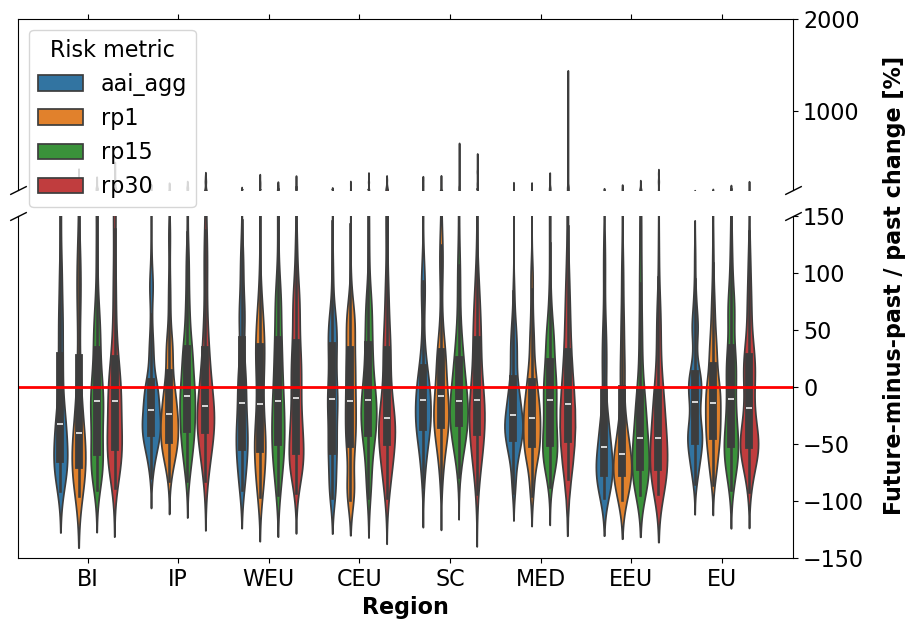

In [10]:
#with axis break
#plotting params
saving = False
met_set = ['aai_agg','rp1','rp15','rp30']
break_ax = True #separate y-axis in two to deal with outliers
savelocation="results/figures/uncertainty/"
bn = "nsamp"+str(N_sample)
savefileName = make_fn(["reg_unc"]+impflist+output_imp.samples_df.columns.tolist(),bn,filetype=".png")
title ='Uncertainty distributions'
cpal = sns.color_palette("tab10")

#labels option
ttsize = 12
sublabsize = 12
gllabsize = 8
cbarlabsize = 16
cbarticksize = 16

#initiate fig
fig = plt.figure(figsize=(10,7))

nrows = 2

gridspec={'height_ratios':np.repeat([1/3,2/3],nrows/2)}
axs = fig.subplots(nrows=nrows,ncols=1,sharey=False,sharex=True,gridspec_kw=gridspec)
fig.subplots_adjust(hspace=0.1)  # adjust space between axes

ax1 = axs[0]
ax2 = axs[1]
sns.violinplot(ax=ax1,x="region",order=reglist, y="value",data=stacked_df,hue="metric",hue_order=met_set,palette=cpal)#palette="colorblind"
sns.violinplot(ax=ax2,x="region",order=reglist, y="value",data=stacked_df,hue="metric",hue_order=met_set,palette=cpal)#palette="Set3"

#bottom axis
ax2.axhline(0,linewidth=2,color="r")
ax2.set_ylabel('')#,fontweight='bold'
ax2.set_xlabel('Region',fontsize = cbarticksize,fontweight='bold')#,fontweight='bold'
ax2.yaxis.set_label_position("right")
ax2.get_legend().remove()
ax2.yaxis.tick_right()
ax2.tick_params(axis='y', labelsize=cbarticksize)
ax2.tick_params(axis='x', labelsize=cbarticksize)

#top axis
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()
#ax1.set_title(title,loc='left',fontsize = cbarticksize,fontweight='bold')
ax1.tick_params(axis='y', labelsize=cbarticksize)
ax1.tick_params(axis='x', labelsize=cbarticksize)
ax1.set_ylabel('')
ax1.set_xlabel('')
ax1.legend(loc="upper left",frameon=True,title='Risk metric',title_fontsize=16)

# zoom-in / limit the view to different portions of the data
ax1.set_ylim(150, 2000)  # outliers only (150, 2000)
#ax1.set_yscale('log')
ax2.set_ylim(-150, 150)  # most of the data (-150, 150)

#common y label
fig.supylabel('Future-minus-past / past change [%]',fontsize = cbarticksize,fontweight='bold',x=0.99)
fig.supylabel

# hide the spines between ax and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()

#add breaks
d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

if saving:
    fig.savefig(savelocation+savefileName,transparent=False,bbox_inches='tight')

In [11]:
## prepare dataframe for sensitivity plots
reg_sens_dict = {}
for reg, out_df in res_dict.items():
    sens_dict = dict()
    for metric in out_df.sensitivity_metrics:
        df = out_df.__dict__[metric + '_sens_df']
        try:
            df.set_index(['param','param2','si'],inplace=True)
        except:
            pass
        sens_dict[metric] = df
    sens_df = pd.concat(sens_dict,axis=1)

    reg_sens_dict[reg] = sens_df.droplevel(0,axis=1)
reg_sens_df = pd.concat(reg_sens_dict,axis=1,names=["region","metric"])


## Plot sensitivity Europe

/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  npdtype = np.dtype(dtype)
/Users/lseverino/miniforge3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/common.py:1636: DeprecationWarning: Converting `np

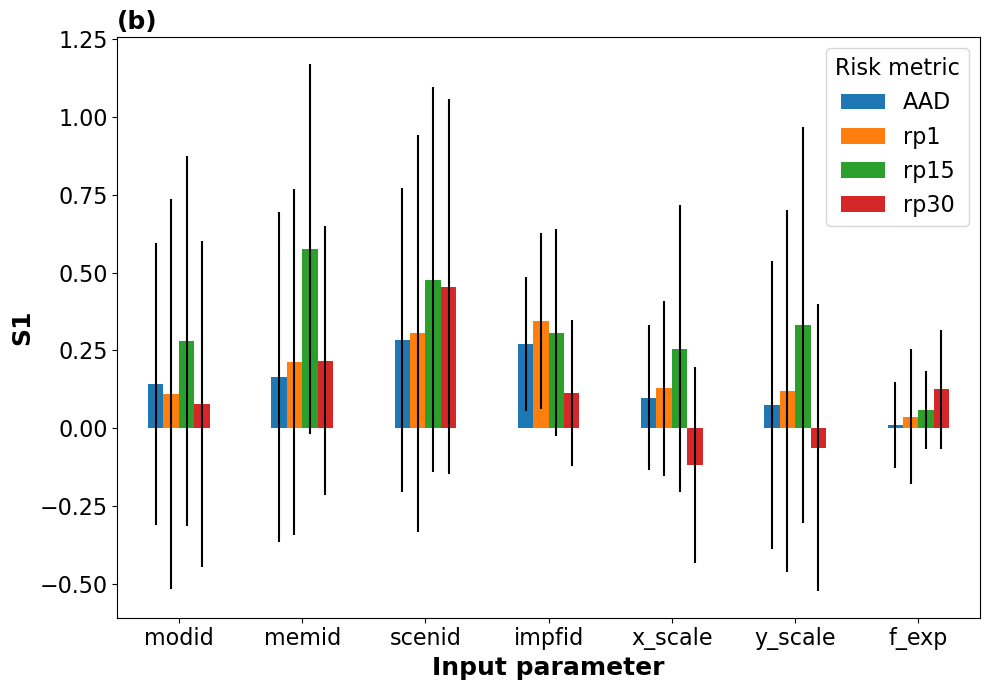

In [12]:
##Plots EU
#select and crop data
output_imp_cropped = cp.deepcopy(res_dict['EU'])
output_imp_cropped = calc_imp.sensitivity(output_imp_cropped)
keep = ['rp1','rp15','rp30']
output_imp_cropped.freq_curve_unc_df = output_imp_cropped.freq_curve_unc_df[keep]
output_imp_cropped.freq_curve_sens_df = output_imp_cropped.freq_curve_sens_df[['si','param','param2']+keep]


saving = False
salib_si = 'S1'
metrics = ['aai_agg','rp1','rp15','rp30']
params = output_imp_cropped.param_labels
#params_sel = ['modid','memid','scenid','impfid']
params_sel = ['modid','memid','scenid','impfid','x_scale','y_scale','f_exp']
#params_sel = ['modid','scenid','impfid','x_scale','y_scale','f_exp']


cols = ['tab:blue','tab:orange','tab:green','tab:red']

salib_si_conf = 'S1_conf'
fig = plt.figure(figsize=(10,7))
ax = fig.subplots(nrows=1,ncols=1)

df_S = output_imp_cropped.get_sensitivity(salib_si).set_index("param")
df_S = df_S.loc[params_sel,metrics]
df_S.columns = ['AAD','rp1', 'rp15', 'rp30']

df_S_conf = output_imp_cropped.get_sensitivity(salib_si_conf).set_index("param")
df_S_conf = df_S_conf.loc[params_sel,metrics]
df_S_conf.columns = ['AAD','rp1', 'rp15', 'rp30']

#if df_S_conf.empty:

#    df_S.plot(ax=ax, kind='bar', **kwargs)
df_S.plot(ax=ax,kind='bar', yerr=df_S_conf)
ax.set_xticklabels(params_sel, rotation=0)
ax.set_xlabel('Input parameter')
ax.set_ylabel(salib_si)
#title = 'a) '+salib_si + ' indices for EU'
title = '(b)'
ax.set_title(title,loc='left')
ax.legend(title='Risk metric',loc='upper right',fontsize=SMALL_SIZE,frameon=True,title_fontsize=SMALL_SIZE)
plt.tight_layout()


## Plots sensitivity regional level

In [13]:
metrics = ['aai_agg','rp15']
si_met = 'S1'
idx = pd.IndexSlice

ss_df = reg_sens_df.loc[:,idx[:,metrics]].query("si==@si_met")
ss_conf_df = reg_sens_df.loc[:,idx[:,metrics]].query("si==@si_met+'_conf'")

ss_df = ss_df.droplevel("param2",axis=0).droplevel("si",axis=0)
ss_conf_df = ss_conf_df.droplevel("param2",axis=0).droplevel("si",axis=0)

#set negative values to 0
#ss_df[ss_df<0] = 0

#drop useless params
params = ['modid','memid','scenid','impfid','f_exp','x_scale','y_scale']
keep = ['modid','memid','scenid','impfid']
keep = params
ss_df = ss_df.loc[keep].T
ss_conf_df = ss_conf_df.loc[keep].T

##Rename aai_agg to AAD
ss_df.index = ss_df.index.set_levels(["AAD",'rp1', 'rp15', 'rp30'],level=1)
ss_conf_df.index = ss_conf_df.index.set_levels(["AAD",'rp1', 'rp15', 'rp30'],level=1)

Text(0.0, 1.0, '(a)')

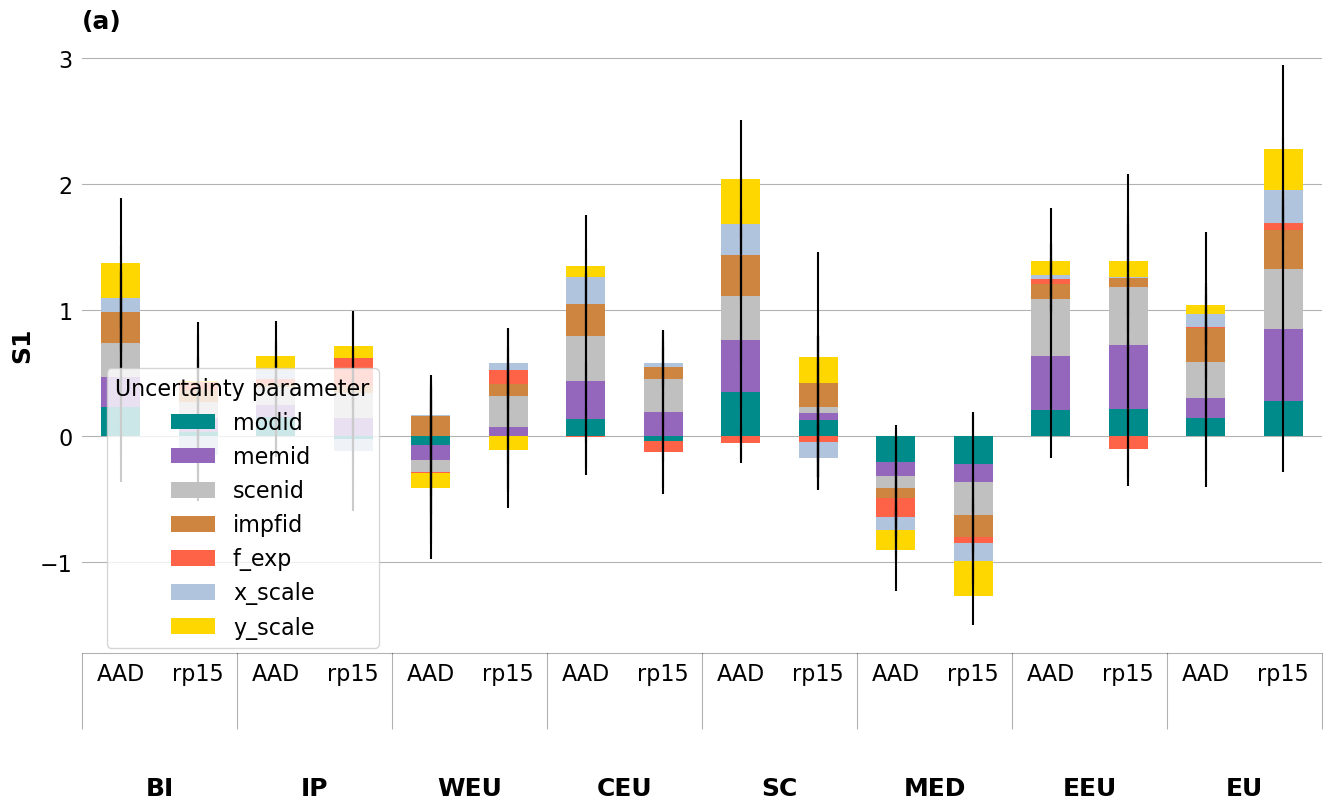

In [14]:
df = ss_df
cols = ['darkcyan', 'tab:purple', 'silver','peru']
cols2 = ['tomato','lightsteelblue','gold']
title = '(a)'

zones = df.index.levels[0]
nplots = zones.size
plots_width_ratios = [df.xs(zone).index.size for zone in zones]
fig, axes = plt.subplots(nrows=1, ncols=nplots, sharey=True, figsize=(16, 8),
                         gridspec_kw = dict(width_ratios=plots_width_ratios, wspace=0))

# Loop through array of axes to create grouped bar chart for each factory zone
alpha = 0.3 # used for grid lines, bottom spine and separation lines between zones
for zone, ax in zip(zones, axes):
    # Create bar chart with grid lines and no spines except bottom one
    df.xs(zone).plot.bar(ax=ax, legend=None, zorder=2,stacked=True,yerr=ss_conf_df.xs(zone),color=cols+cols2)
    ax.grid(axis='y', zorder=1, color='black', alpha=alpha)
    for spine in ['top', 'left', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['bottom'].set_alpha(alpha)

    # Set and place x labels for factory zones
    ax.set_xlabel(zone)
    ax.xaxis.set_label_coords(x=0.5, y=-0.2)

    # Format major tick labels for factory names: note that because this figure is
    # only about 10 inches wide, I choose to rewrite the long names on two lines.
    ticklabels = [name.replace(' ', '\n') if len(name) > 10 else name
                  for name in df.xs(zone).index]
    ax.set_xticklabels(ticklabels, rotation=0, ha='center')
    ax.tick_params(axis='both', length=0, pad=7)

    # Set and format minor tick marks for separation lines between zones: note
    # that except for the first subplot, only the right tick mark is drawn to avoid
    # duplicate overlapping lines so that when an alpha different from 1 is chosen
    # (like in this example) all the lines look the same
    if ax.get_subplotspec().is_first_col():
        ax.set_xticks([*ax.get_xlim()], minor=True)
    else:
        ax.set_xticks([ax.get_xlim()[1]], minor=True)

    ax.tick_params(which='minor', length=55, width=0.8, color=[0, 0, 0, alpha])
    ax.set_ylabel(si_met)
#fig.supxlabel('Regions')

# Add legend using the labels and handles from the last subplot
fig.legend(*ax.get_legend_handles_labels(), frameon=True,loc=(0.08, 0.2),title='Uncertainty parameter',title_fontsize=16)#loc='lower left'

#fig.suptitle('(b)', y=1, size=14);
axes[0].set_title(title,loc='left')
